전이 학습으로 다른 데이터셋의 추출 정보를 가져와서 예측률을 높일 수 있다. 이것이 전이학습이다.

기존의 학습 결과를 가져와서 유사한 프로젝트에 사용할 수 있는데, 이는 '형태 구분'에 대한 기본적인 학습이 되어있기 때문이다. 즉 어떤 픽셀 조합이 선이고 면이 되는 지 미리 학습이 되어있다는 것이다.

기존 모델을 새로운 모델의 앞쪽에 불러온다.
이 두 네트워크가 잘 연결되게 fine tuning 해야한다.

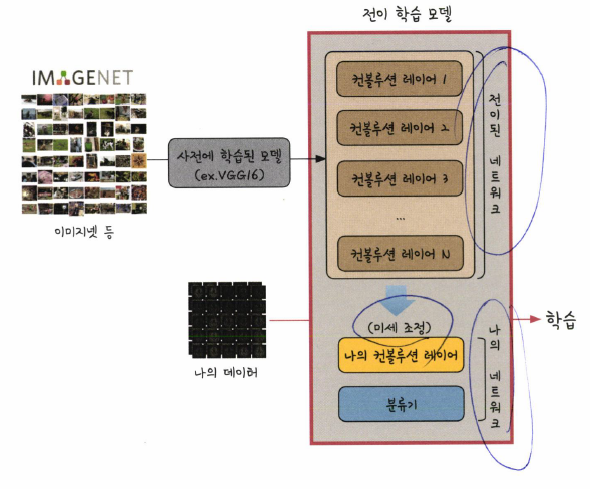

VGGNet을 가지고 와보자.

In [1]:
# 데이터 준비
from google.colab import files
uploaded = files.upload()

## colab > run_project 폴더에 있는 colab_train_test.zip 파일을 선택합니다.
my_data = 'colab_train_test.zip'
!unzip colab_train_test.zip

Saving colab_train_test.zip to colab_train_test.zip
Archive:  colab_train_test.zip
   creating: test/ad/
  inflating: test/ad/ad_test_1.jpg   
  inflating: test/ad/ad_test_10.jpg  
  inflating: test/ad/ad_test_11.jpg  
  inflating: test/ad/ad_test_12.jpg  
  inflating: test/ad/ad_test_13.jpg  
  inflating: test/ad/ad_test_14.jpg  
  inflating: test/ad/ad_test_15.jpg  
  inflating: test/ad/ad_test_16.jpg  
  inflating: test/ad/ad_test_17.jpg  
  inflating: test/ad/ad_test_18.jpg  
  inflating: test/ad/ad_test_19.jpg  
  inflating: test/ad/ad_test_2.jpg   
  inflating: test/ad/ad_test_20.jpg  
  inflating: test/ad/ad_test_21.jpg  
  inflating: test/ad/ad_test_22.jpg  
  inflating: test/ad/ad_test_23.jpg  
  inflating: test/ad/ad_test_24.jpg  
  inflating: test/ad/ad_test_25.jpg  
  inflating: test/ad/ad_test_26.jpg  
  inflating: test/ad/ad_test_27.jpg  
  inflating: test/ad/ad_test_28.jpg  
  inflating: test/ad/ad_test_29.jpg  
  inflating: test/ad/ad_test_3.jpg   
  inflating: test/ad/

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Input, models, layers, optimizers, metrics
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.applications import VGG16

np.random.seed(3)
tf.random.set_seed(3)

train_datagen = ImageDataGenerator(rescale=1./255,
                                  horizontal_flip=True,
                                  width_shift_range=0.1,
                                  height_shift_range=0.1,
                                  fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(
       'train',
       target_size=(150, 150),
       batch_size=5,
       class_mode='binary')

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
       'test',
       target_size=(150, 150),
       batch_size=5,
       class_mode='binary')

Found 160 images belonging to 2 classes.
Found 120 images belonging to 2 classes.


In [3]:
# 외부 모델 불러오기
transfer_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3)) # include top : 분류 기능이 있는 마지막 층을 가져오는가? 로컬 네트워크를 연결하려면 False로 해야한다.
transfer_model.trainable = False   # 새로 학습하는 것 아니므로
transfer_model.summary()

"""
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
=================================================================
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 37, 37, 256)       295168    
                                                                 
 block3_conv2 (Conv2D)       (None, 37, 37, 256)       590080    
                                                                 
 block3_conv3 (Conv2D)       (None, 37, 37, 256)       590080    
                                                                 
 block3_pool (MaxPooling2D)  (None, 18, 18, 256)       0         
                                                                 
 block4_conv1 (Conv2D)       (None, 18, 18, 512)       1180160   
                                                                 
 block4_conv2 (Conv2D)       (None, 18, 18, 512)       2359808   
                                                                 
 block4_conv3 (Conv2D)       (None, 18, 18, 512)       2359808   
                                                                 
 block4_pool (MaxPooling2D)  (None, 9, 9, 512)         0         
                                                                 
 block5_conv1 (Conv2D)       (None, 9, 9, 512)         2359808   
                                                                 
 block5_conv2 (Conv2D)       (None, 9, 9, 512)         2359808   
                                                                 
 block5_conv3 (Conv2D)       (None, 9, 9, 512)         2359808   
                                                                 
 block5_pool (MaxPooling2D)  (None, 4, 4, 512)         0         
                                                                 
=================================================================
Total params: 14,714,688
Trainable params: 0    <------------- 학습 가능한 파라미터가 없다. 즉 VGGnet은 학습 없이 그대로 사용한다.
Non-trainable params: 14,714,688
_________________________________________________________________
"""

58900480/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                              

'\nModel: "vgg16"\n_________________________________________________________________\n Layer (type)                Output Shape              Param #   \n=================================================================\n input_1 (InputLayer)        [(None, 150, 150, 3)]     0         \n                                                                 \n block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      \n                                                                 \n block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     \n                                                                 \n block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         \n                                                                 \n block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     \n                                                                 \n block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    \n                                           

In [4]:
finetune_model = models.Sequential()
finetune_model.add(transfer_model)  # VGG 추가
# 최종 예측 층 추가
finetune_model.add(Flatten())
finetune_model.add(Dense(64, activation='relu'))
finetune_model.add(Dense(2, activation='softmax'))
finetune_model.summary()

"""
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
=================================================================
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 64)                524352    
                                                                 
 dense_1 (Dense)             (None, 2)                 130       
                                                                 
=================================================================
Total params: 15,239,170
Trainable params: 524,482 <-- 최종 예측 층만 학습
Non-trainable params: 14,714,688
_________________________________________________________________
"""

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 64)                524352    
                                                                 
 dense_1 (Dense)             (None, 2)                 130       
                                                                 
Total params: 15,239,170
Trainable params: 524,482
Non-trainable params: 14,714,688
_________________________________________________________________


'\nModel: "sequential"\n_________________________________________________________________\n Layer (type)                Output Shape              Param #   \n=================================================================\n vgg16 (Functional)          (None, 4, 4, 512)         14714688  \n                                                                 \n flatten (Flatten)           (None, 8192)              0         \n                                                                 \n dense (Dense)               (None, 64)                524352    \n                                                                 \n dense_1 (Dense)             (None, 2)                 130       \n                                                                 \n=================================================================\nTotal params: 15,239,170\nTrainable params: 524,482 <-- 최종 예측 층만 학습\nNon-trainable params: 14,714,688\n_________________________________________________________________\n'

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  # Remove the CWD from sys.path while we load stuff.


Epoch 1/20
32/32 [==============================] - 55s 2s/step - loss: 0.3361 - accuracy: 0.8500 - val_loss: 0.3036 - val_accuracy: 0.8750
Epoch 2/20
32/32 [==============================] - 54s 2s/step - loss: 0.2268 - accuracy: 0.9250 - val_loss: 0.2213 - val_accuracy: 0.9250
Epoch 3/20
32/32 [==============================] - 54s 2s/step - loss: 0.1689 - accuracy: 0.9625 - val_loss: 0.1921 - val_accuracy: 0.9333
Epoch 4/20
32/32 [==============================] - 54s 2s/step - loss: 0.1520 - accuracy: 0.9688 - val_loss: 0.1669 - val_accuracy: 0.9417
Epoch 5/20
32/32 [==============================] - 54s 2s/step - loss: 0.1310 - accuracy: 0.9563 - val_loss: 0.1879 - val_accuracy: 0.9333
Epoch 6/20
32/32 [==============================] - 54s 2s/step - loss: 0.1237 - accuracy: 0.9688 - val_loss: 0.1465 - val_accuracy: 0.9500
Epoch 7/20
32/32 [==============================] - 54s 2s/step - loss: 0.1433 - accuracy: 0.9375 - val_loss: 0.2232 - val_accuracy: 0.9000
Epoch 8/20
32/32 [==

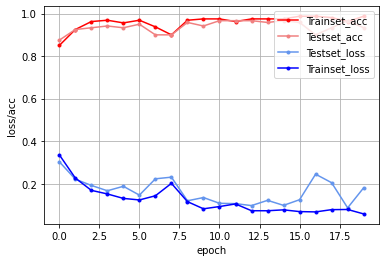

In [11]:
finetune_model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizers.Adam(learning_rate=0.0002), metrics=['accuracy'])

history = finetune_model.fit_generator(
       train_generator,
      #  steps_per_epoch = 100,
      steps_per_epoch = len(train_generator),
       epochs = 20,
       validation_data = test_generator,
      #  validation_steps = 4
       validation_steps = len(test_generator))

acc= history.history['accuracy']
val_acc= history.history['val_accuracy']
y_vloss = history.history['val_loss']
y_loss = history.history['loss']

# 그래프로 표현
x_len = np.arange(len(y_loss))
plt.plot(x_len, acc, marker='.', c="red", label='Trainset_acc')
plt.plot(x_len, val_acc, marker='.', c="lightcoral", label='Testset_acc')
plt.plot(x_len, y_vloss, marker='.', c="cornflowerblue", label='Testset_loss')
plt.plot(x_len, y_loss, marker='.', c="blue", label='Trainset_loss')

# 그래프에 그리드를 주고 레이블을 표시
plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss/acc')
plt.show()

# 카글, 논문, 깃헙

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  if __name__ == '__main__':
Epoch 1/20
 32/100 [========>.....................] - ETA: 1:06 - loss: 0.6054 - accuracy: 0.7000WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 2000 batches). You may need to use the repeat() function when building your dataset.
100/100 [==============================] - 37s 350ms/step - loss: 0.6054 - accuracy: 0.7000 - val_loss: 0.3578 - val_accuracy: 0.9500

이 버그를 해결하기 위해
https://stackoverflow.com/questions/59864408/tensorflowyour-input-ran-out-of-data/66057615


history = finetune_model.fit_generator(
       train_generator,
      steps_per_epoch = len(train_generator),
       epochs = 20,
       validation_data = test_generator,
       validation_steps = len(test_generator))

라고 코드 수정
원인은 dataset의 batchsize가 안맞기 때문이다.